# Calculating and testing extension calculation


In [1]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [2]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension
from crabmeyerpy.photonfields import black_body, j_dust_carbon_shell
from crabmeyerpy.data import CrabData
from scipy.integrate import simps, romb
from nonthermal.sync import Esync_peak, gamma_sync_peak
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time
import os
from scipy.interpolate import RectBivariateSpline, UnivariateSpline

In [3]:
%load_ext autoreload
%autoreload 2

# 3D model

Initialize the 3D model

In [4]:
#The magnetic field strength and the distance to the nebula
B = 124e-6  # B Field in G
d = 2.  # distance to nebula in kpc

In [5]:
# config to match 1D case
config = {
    # electron spectrum parameters
    "Nradio": np.exp(-9.5) * 1.3, # these are just some scalings
    "gradio_min": np.exp(3.1),
    "gradio_max": np.exp(12.1),
    "Sradio": -1.60,
    "Nwind": np.exp(-48.) * 2, # these are just some scalings
    "gmin": np.exp(3.1),
    "gmax": np.exp(30.),
    "gwind_min": np.exp(13.1),
    "gwind_max": np.exp(22.6),
    "gwind_b": 1. / np.exp(19.5),
    "Swind": -2.85,
    "Sbreak": -0.6, 
    "sup_wind": 2.8,
    # spatial parameters, this is new
    "radio_size_cm": np.tan(1.35 * arcmin2rad) * d * kpc2cm ,  # constant size of Gaussian below gamma_br_constant in arcmin 
    "index": -0.14,  # power-law index of energy dependency
    # new dust model parameters
    'dust_T1': 151.,
    'dust_T2': 37.,
    'log10_M1': -4.37,
    'log10_M2': -1.1,
    'abs_norm': 2.15e4,
    'abs_index': 1.3,
    'r_min': 0.55 / 1e3 * kpc2cm,
    'r_max': 1.5 / 1e3 * kpc2cm,
    "ic_sync": True, 
    "ic_dust": True,
    "ic_cmb": True,
    "B": B
}

Some tuned values to fit the extension in sync

In [6]:
# config to match 1D case
config = {
    # electron spectrum parameters
    "Nradio": np.exp(-9.5) * 1.3, # these are just some scalings
    "gradio_min": np.exp(3.1),
    "gradio_max": np.exp(12.1),
    "Sradio": -1.60,
    "Nwind": np.exp(-47.5), # these are just some scalings
    "gmin": np.exp(3.1),
    "gmax": np.exp(30.),
    "gwind_min": np.exp(13.1),
    "gwind_max": np.exp(22.6),
    "gwind_b": 1. / np.exp(19.5),
    "Swind": -2.6,
    "Sbreak": -0.6, 
    "sup_wind": 2.8,
    # spatial parameters, this is new
    # original values
    "radio_size_cm": np.tan(1.35 * arcmin2rad) * d * kpc2cm * 1.5,  # constant size of Gaussian below gamma_br_constant in arcmin 
    "index": -0.2,  # power-law index of energy dependency
    # new dust model parameters
    'dust_T1': 151.,
    'dust_T2': 37.,
    'log10_M1': -4.37,
    'log10_M2': -1.1,
    'abs_norm': 2.15e4,
    'abs_index': 1.3,
    'r_min': 0.55 / 1e3 * kpc2cm,
    'r_max': 1.5 / 1e3 * kpc2cm,
    "ic_sync": True, 
    "ic_dust": True,
    "ic_cmb": True,
    "B": B
}

In [7]:
# maximum radius of nebula
# This number should probably be updated to newer values
# it comes from Atoyan & Aharonian 1996
r0_pc = 1.8
r0_pc = 4 * 1.8

### Read in some extension data

In [8]:
# read in parameters from Tim
in_dir = "/Users/manuelmeyer/Dropbox/Projects/Crab/data4Manuel/"

#config = np.load(os.path.join(in_dir, "04_all_gaussradio_newdust.npy"), allow_pickle=True).flat[0]  #KC model
#config = np.load(os.path.join(in_dir, "v18_hess1+2+mono_newdust_08.npy"), allow_pickle=True).flat[0]  # const B model

# Dieter's crab points
ext_horns=np.loadtxt(os.path.join(in_dir, 'Crab_ext_Horns_erratum.txt'), delimiter=';')

x_horns=(ext_horns[:,0]*u.GeV).to_value("TeV")

fac=np.sqrt(x_horns[1:] / x_horns[:-1])
facs=np.array([1.40251572, 1.40251572, 1.41, 1.415, 1.4, 1.39 , 3, 4])

x_err_horns_p=(facs-1)*x_horns
x_err_horns_n=x_horns*(1-1/facs)

sig_horns=(ext_horns[:,1]*u.deg)#.to_value("arcmin")
err_p_horns=(ext_horns[:,2]*u.deg-sig_horns).to_value("arcmin")
err_n_horns=(sig_horns-ext_horns[:,3]*u.deg).to_value("arcmin")

radio_extensions=np.loadtxt(os.path.join(in_dir,"radio_extensions.txt"), usecols=[0,1,2]) # freq, r68, err r68
radio_extensions[:,0] *= (c.h*u.Hz).to_value('TeV') # convert freq to TeV

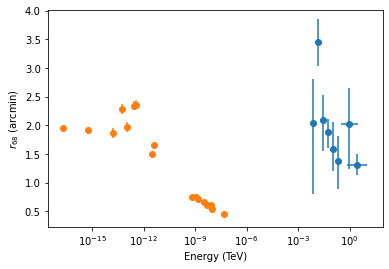

In [9]:
def plot_data(ax=None, y_unit="arcmin", x_unit="TeV"):
    if ax is None:
        ax = plt.gca()
    ax.errorbar(x_horns * u.TeV.to(x_unit),
                sig_horns.to_value(y_unit),
                xerr=[x_err_horns_n * u.TeV.to(x_unit), x_err_horns_p * u.TeV.to(x_unit)],
                yerr=[err_n_horns * u.arcmin.to(y_unit), err_p_horns * u.arcmin.to(y_unit)],
                ls="none", marker="o")
    ax.set_xscale("log")

    ax.errorbar(radio_extensions[:,0] * u.TeV.to(x_unit),
                radio_extensions[:,1] * u.arcsec.to(y_unit),
                yerr=radio_extensions[:,2] * u.arcsec.to(y_unit),
                ls="none", marker="o")
    ax.set_xlabel(f"Energy ({x_unit})")
    ax.set_ylabel(f"$r_{{68}}$ ({y_unit})")
    
plot_data()

### Define the electron spectrum

In [10]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab(gamma, **params) * nel_crab_extension(r, gamma, **params)

# the assumed radial dependence of the magnetic field
def const_B(r, **params):
    result = np.full(r.shape, params['B'])
    return result

Initialize the model

In [11]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, const_B, j_dust_carbon_shell, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG", 
                ic_sync=True, ic_cmb=True, ic_dust=True)

In [12]:
print(np.arctan(config['radio_size_cm'] / ssc.d) / arcmin2rad)  # radio size in arcmin
print(config['radio_size_cm'] / kpc2cm * 1e3)  # radio size in pc
print(ssc.theta_max_arcmin(), ssc.r0, ssc.d)   # maximum extension of nebule (given by r0 and d), r0, d

2.0249998698831644
1.1780973056553103
12.375834911403732 2.2216878586737844e+19 6.171355162982735e+21


## Calculate the full SED

Do one pass of the full SED calculation.

In [13]:
# define r and nu arrays
r = np.linspace(0., ssc.r0, 10)
nu_all = np.logspace(7., 31., 300)

nu_sync = nu_all[nu_all <=1e25]
nu_ic = nu_all[nu_all >= 1e20]

# steps for intensity and flux 
# in radial distance
theta_steps = 20

In [14]:
# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

In [15]:
# Calculate the intensities along the line of sight
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu_sync, theta=theta_steps)
I_nu_dust, _, _ = ssc.intensity2(nu_sync, theta=theta_steps, which='dust')

print("theta_arcmin:", theta_arcmin)


# Calculate the fluxes
f_nu_sync = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='sync',
                     integration_mode='romb',
                     theta_steps=33)

f_nu_dust = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='dust',
                     integration_mode='romb',
                     theta_steps=33)

/Users/manuelmeyer/Python/miniforge3/envs/basic/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../fast_interp/fast_interp/fast_interp.py", line 329:
@numba.njit(parallel=True)
def _interp2d_k1(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/manuelmeyer/Python/miniforge3/envs/basic/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/depr

theta_arcmin: [ 0.          0.64484613  1.28969227  1.9345384   2.57938454  3.22423067
  3.86907681  4.51392294  5.15876908  5.80361521  6.44846135  7.09330748
  7.73815362  8.38299975  9.02784589  9.67269202 10.31753816 10.96238429
 11.60723043 12.25207656]


#### IC component

In [16]:
# Calculate the IC emissivity
r_ic_egdes = np.linspace(0., ssc.r0, 33)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 129  # steps for integration over gamma
e_steps = 129  # steps for integration over energy of seed photon field
r1_steps = 65   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

 ssc_3d.py: 702 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 703 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 711 --- DEBUG: phot_dens: time for interpolation of Sync: 0.007s, time for integration of SSC component  0.007s,  time for filling arrays 0.002s 
 ssc_3d.py: 536 --- DEBUG: Dust calculation in j_dust_nebula function took 0.014s
 ssc_3d.py: 753 --- DEBUG: time to calculate grey body 0.016s  time for integration of dust component  0.004s
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 872 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 880 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 897 --- DEBUG: integration over photon dens and gamma took 4.903s


In [17]:
# calculate the intensity along the line of sight
I_nu_ic, _, _ = ssc.intensity2(nu_ic, theta=theta_steps, which='ic')

# calculate the IC flux
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)

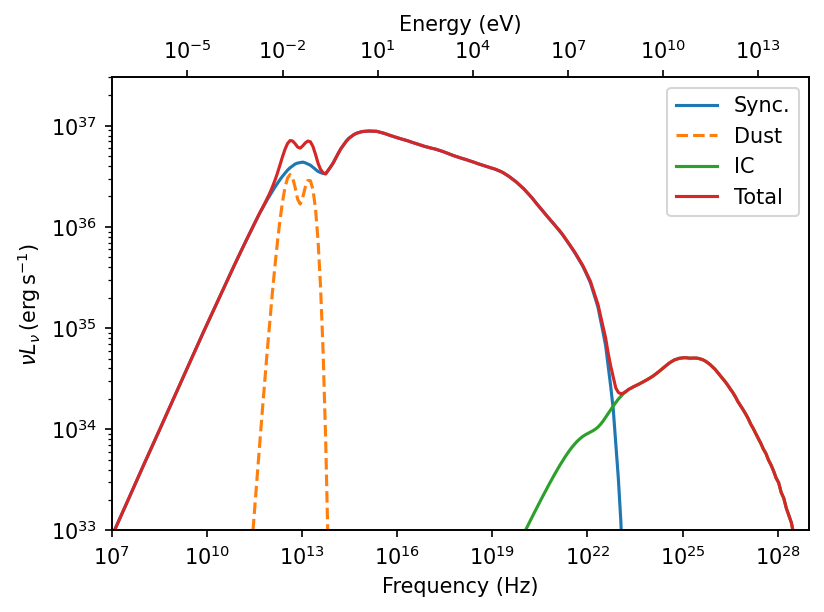

In [18]:
# plotting function to show full sed
def plot_full_sed(luminosity=True, ic=True, sync=True, dust=True, total=True, dpi=150, fig=None, ax=None):
    if fig is None:
        fig = plt.figure(dpi=dpi)

    if ax is None:
        ax = fig.add_subplot(111)
        
    if luminosity:
        const = 4. * np.pi * (d * kpc2cm)**2
    else:
        const = 1.

    if sync:
        ax.loglog(nu_sync, f_nu_sync * nu_sync * const, ls='-', label="Sync.")
    if dust:
        ax.loglog(nu_sync, f_nu_dust * nu_sync * const, ls='--', label="Dust")
    if ic:
        ax.loglog(nu_ic, f_nu_ic * nu_ic * const, ls='-', label="IC")
    if total:
        f_all = np.zeros_like(nu_all)
        m_sync = nu_all <= nu_sync[-1]
        m_ic = nu_all >= nu_ic[0]
        
        f_all[m_sync] += f_nu_sync
        f_all[m_sync] += f_nu_dust
        f_all[m_ic] += f_nu_ic
        
        ax.loglog(nu_all, f_all * nu_all * const, ls='-', label="Total")
    
    if luminosity:
        ax.set_ylim(1e33,3e37)
        ax.set_ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")    

    else:
        ax.set_ylim(1e-13, 1e-7)
        ax.set_ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}$)")    
        
    ax.set_xlim(1e7,1e29)
    ax2 = ax.twiny()
    ax2.set_xlim(1e7 * c.h.to("eV s").value, 1e29 * c.h.to("eV s").value)
    ax2.set_xscale("log")
    ax.set_xlabel("Frequency (Hz)")
    ax2.set_xlabel("Energy (eV)")
    return fig, ax

fig, ax = plot_full_sed()
ax.legend()


## The predicted extension

The next cells demonstrate how we can calculate the 68% extension radius. 

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

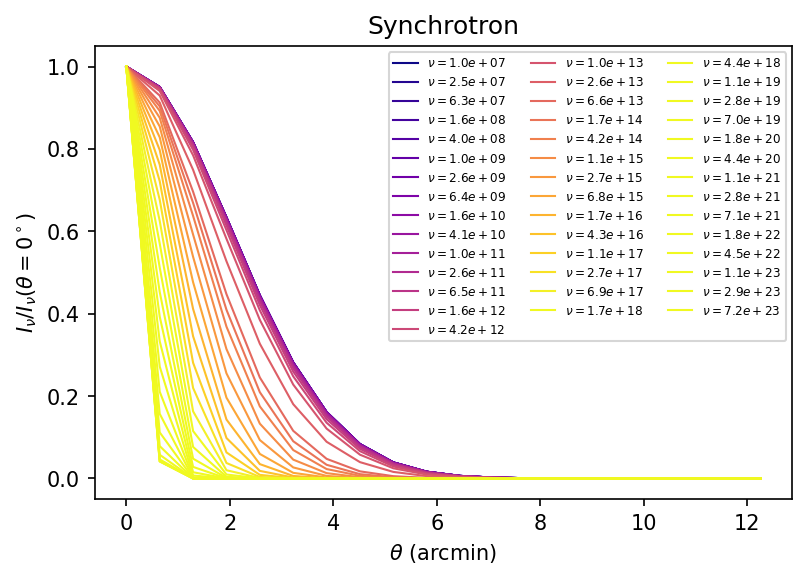

In [19]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_sync[:-10]):
    if i % 5:
        continue
        
    plt.plot(theta_arcmin, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$\nu={0:.1e}$".format(n),
               lw=1
            )

plt.title("Synchrotron")
plt.legend(ncol=3, fontsize='xx-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

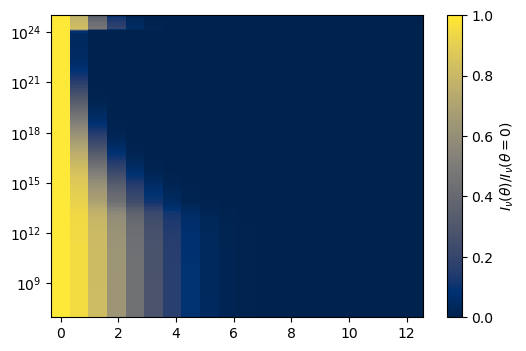

In [20]:
# plot a 2D version of the intensity
plt.figure(dpi=100)
im = plt.pcolormesh(theta_arcmin, nu_sync, (I_nu_sync.T / I_nu_sync[:,0]).T, cmap="cividis", shading="auto")
plt.colorbar(im, label=r"$I_\nu(\theta) / I_{\nu}(\theta=0)$")
plt.yscale("log")

In [21]:
#Interpolate the intensity
m = nu_sync < 1e24
I_nu_sync_interp = RectBivariateSpline(np.log10(nu_sync[m]), theta_arcmin, np.log10(I_nu_sync[m,:]), kx=2, ky=2)

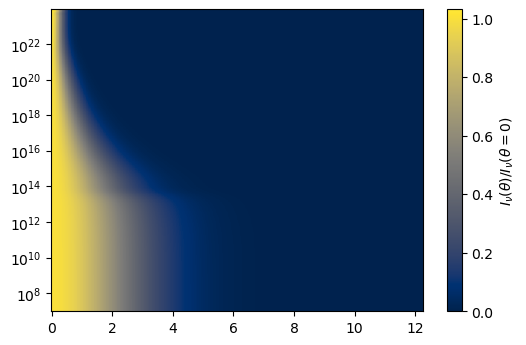

In [22]:
# test the interpolation
plt.figure(dpi=100)
t_test = np.linspace(theta_arcmin[0], theta_arcmin[-1], 500)
log_nu_test = np.linspace(np.log10(nu_sync[m])[0], np.log10(nu_sync[m])[-1], 501)

Iinterp = 10.**I_nu_sync_interp(log_nu_test, t_test)

im = plt.pcolormesh(t_test, 10.**log_nu_test, (Iinterp.T / Iinterp[:,0]).T, cmap="cividis", shading="auto")
plt.colorbar(im, label=r"$I_\nu(\theta) / I_{\nu}(\theta=0)$")
plt.yscale("log")

In [23]:
# calculate the fluxes between theta bounds,
# assuming I to be constant within bounds
dtheta = t_test[1:] - t_test[:-1]
theta_cen = 0.5 * (t_test[1:] + t_test[:-1])
f_interp = 0.5 * (Iinterp[:,1:] + Iinterp[:,:-1])  * dtheta

# compute CDF
cdf_interp = np.cumsum(f_interp, axis=1)
cdf_interp = (cdf_interp.T - cdf_interp.min(axis=1)).T
cdf_interp = (cdf_interp.T / cdf_interp.max(axis=1)).T

print(cdf_interp.shape)

(501, 499)


Text(0, 0.5, 'CDF')

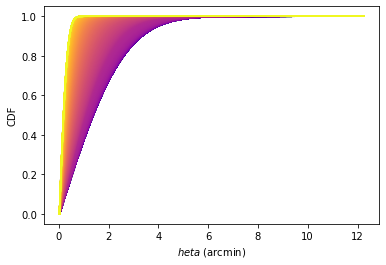

In [24]:
# plot for checking
for i in range(cdf_interp.shape[0]):
    plt.plot(t_test[1:], cdf_interp[i], color=plt.cm.plasma(i / cdf_interp.shape[0]))
plt.xlabel("$\theta$ (arcmin)")
plt.ylabel("CDF")

In [25]:
# compute 68% quantile from nearest index
idx68 = np.argmin(np.abs(cdf_interp - 0.68), axis=1)

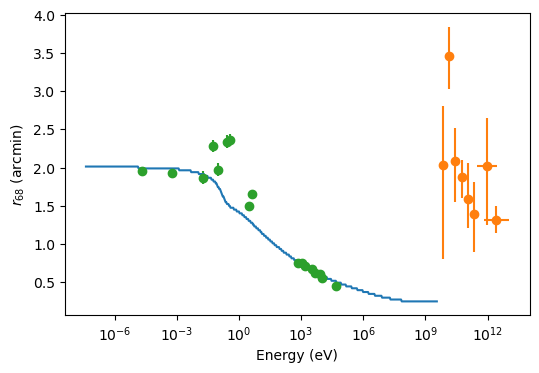

In [26]:
# the final result and comparison to data
plt.figure(dpi=100)
plt.semilogx(10.**log_nu_test / eV2Hz, t_test[idx68])
plot_data(x_unit="eV")

### Do the same steps but from a function of `ssc`

Now we perform the same steps for both the synchrotron and IC part but using a built-in function of the `ssc` object. 

In [27]:
nu68_sync, r68_sync = ssc.ext68(nu_sync, which='sync', theta_steps_interp=4 * 500)
nu68_ic, r68_ic = ssc.ext68(nu_ic, which='ic', theta_steps_interp=4 * 500)

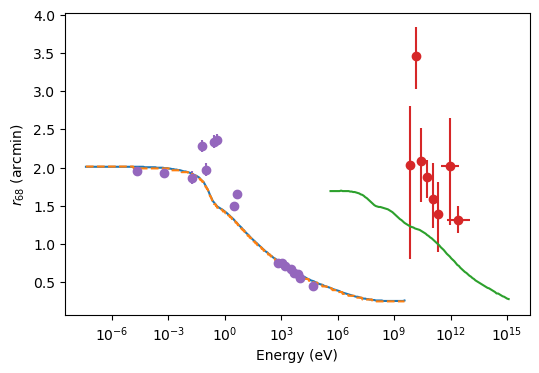

In [28]:
# compare the results
plt.figure(dpi=100)
plt.semilogx(nu68_sync / eV2Hz, r68_sync)
plt.semilogx(10.**log_nu_test / eV2Hz, t_test[idx68], ls='--')
plt.semilogx(nu68_ic / eV2Hz, r68_ic)

plot_data(x_unit="eV")